In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import convolution as conv
from astropy.time import Time
import datetime
import glob
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from pprint import pprint
import scipy as sp
from scipy.interpolate import griddata
from scipy import sparse, signal, stats
import scipy.ndimage.morphology as morph
import sunpy.cm as cm
import sunpy.map
import sunpy.physics.differential_rotation as dr
import torch.nn.functional as F

import sys, os

os.environ["CUDA_VISIBLE_DEVICES"]=""

sys.path.append("../../../")
from source.pipeline.model_manager import BaseScaler
from source.pipeline.models.highresnet import HighResNet
from source.pipeline.models.highresnet_rprc import HighResNet_RPRC
from source.pipeline.models.highresnet_rprcdo import HighResNet_RPRCDO
from source.pipeline.losses.baseline_loss import MSELoss, L1Loss
from source.pipeline.entropy import Entropy

from source.pipeline.metrics_denoised_hist import DenoisedHistogram
from source.pipeline.metrics import *

from source.patch_stitch import get_patch
from source.patch_stitch import get_img_from_patch
from source.multiframe import register

from skimage.transform import resize

import torch
import torch.nn as nn
import yaml

%matplotlib inline

In [4]:
# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
client = storage.Client()

In [5]:
# Remove Warnings
# import warnings
# warnings.filterwarnings('ignore')

# Color Axis limits
vmin = -2000
vmax = 2000

# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Colormap Definition
current_cmap = plt.cm.get_cmap('hmimag')
# current_cmap = plt.cm.get_cmap('seismic')
current_cmap.set_bad(color='black')

device = torch.device('cuda')

In [7]:
#run = 'MDI_HMI_1_patch_all128_128_20190827214120_HighRes_net_GradientLoss_756_0.0001_GradientLoss'
#epoch = 'epoch_5'
#config_path = '../../../configs/experiments/MDI_HMI_1_P_GradientLoss/MDI_HMI_1_P_highresnet_gradient.yml'

#run = 'MDI_HMI_1_patch_all128_128_20190829112748_HighRes_net_KLDivLoss_32_0.0001_KLDivLoss'
#epoch = 'epoch_7'
#config_path = '../../../configs/experiments/MDI_HMI_1_P_KLDivLoss/MDI_HMI_1_P_highresnet_kldiv.yml'

#run = 'MDI_HMI_1_patch_all128_128_20190830031643_HighRes_net_KLGradLoss_756_0.0001_KLGradLoss'
#epoch = 'epoch_5'
#config_path = '../../../configs/experiments/MDI_HMI_1_P_KLGradLoss/MDI_HMI_1_P_highresnet_klgrad.yml'

# run = 'to-ml-register-nodiff_20200205141537_HighRes_net_HistLoss_64_0.0001_HistLoss_buckets'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_Hist/MDI_HMI_1_P_highresnet_hist.yml'

# run = 'to-ml-register-nodiff_20200208140946_HighRes_net_RP_GradHistLoss_64_0.0001_GradHistLoss'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_GradHistLoss/MDI_HMI_1_P_highresnet_gradhist.yml'

# run = 'to-ml-register-nodiff_20200207210302_HighRes_net_RP_HistLoss_64_0.0001_HistLoss_buckets'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_Hist/MDI_HMI_1_P_highresnet_hist.yml'

# run = 'to-ml-register-nodiff_20200207225855_HighRes_net_RP_SSIMLoss_64_0.0001_HistLoss_buckets'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM/MDI_HMI_HRN_RP_SSIM.yml'


# ## MSE without alignment
# run = 'to-ml_20200205143318_HighRes_net_MSELoss_64_0.0001_MSELoss'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_MSE/MDI_HMI_1_P_highresnet_mse_NA.yml'
# label = 'MSE_dec_not_aligned'

## MSE 
# run = 'to-ml-register-nodiff_20200207183339_HighRes_net_RP_MSELoss_64_0.0001_MSE_HRN_RP'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_MSE/MDI_HMI_1_P_highresnet_mse.yml'
# label = 'MSE_dec'

# # MSE with convection rescale 
# run = 'to-ml-register-nodiff_20200210222555_HighResNet_RPRC_MSELoss_64_0.0001_MSE_HRN_RP_RC'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_MSE/MDI_HMI_1_P_highresnet_mse_rprc.yml'
# label = 'MSE_res_conv'


# # MSE with convection rescale and new data
# run = 'to-ml-register-template_20200216025827_HighResNet_RPRC_MSELoss_64_0.0001_MSE_HRN_RP_RC_temp'
# epoch = 'epoch_16'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_MSE/MDI_HMI_1_P_highresnet_mse_rprc_temp.yml'
# label = 'MSE_res_conv_temp'

# # # MSE with convection rescale and new data and Pixel shift
# run = 'to-ml-register-template_20200330132515_HighResNet_RPRCDOPS_MSELoss_64_0.0001_MSE_HRN_RP_RC_temp'
# epoch = 'epoch_17'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_MSE/MDI_HMI_1_P_highresnet_mse_ps_temp.yml'
# label = 'MSE_res_conv_temp_PS'


# # # MSE with convection rescale and new data and weight normalization
# run = 'to-ml-register-template_20200330132614_HighResNet_RPRCDOWN_MSELoss_64_0.0001_MSE_HRN_RP_RC_temp'
# epoch = 'epoch_16'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_MSE/MDI_HMI_1_P_highresnet_mse_wn_temp.yml'
# label = 'MSE_res_conv_temp_WN'


# # ## Histogram loss 
# run = 'to-ml-register-nodiff_20200207210302_HighRes_net_RP_HistLoss_64_0.0001_HistLoss_buckets'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_Hist/MDI_HMI_1_P_highresnet_hist.yml'

# # # ## Histogram loss with convection rescale
# run = 'to-ml-register-nodiff_20200211005711_HighResNet_RPRC_HistLoss_64_0.0001_HistLoss_RPRC'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_Hist/MDI_HMI_1_P_highresnet_RPRC_hist.yml'
# label = 'Hist_res_conv'

# # # ## Histogram loss with convection rescale and new data
# run = 'to-ml-register-template_20200216031406_HighResNet_RPRC_HistLoss_64_0.0001_HistLoss_RPRC_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_Hist/MDI_HMI_1_P_highresnet_RPRC_hist_temp.yml'
# label = 'Hist_res_conv_temp2'


# # # ## Histogram loss with convection rescale and new data
# run = 'to-ml-register-template_20200218190822_HighResNet_RPRC_HistLoss_64_0.0001_HistLoss_RPRC_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_Hist/MDI_HMI_1_P_highresnet_RPRC_hist_temp.yml'
# label = 'Hist_res_conv_temp'


# # # ## SSIM loss
# run = 'to-ml-register-nodiff_20200207225855_HighRes_net_RP_SSIMLoss_64_0.0001_HistLoss_buckets'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM/MDI_HMI_HRN_RP_SSIM.yml'
# label = 'SSIM_dec'

# # # ## SSIM loss with resize convolution
# run = 'to-ml-register-nodiff_20200212024938_HighResNet_RPRC_SSIMLoss_64_0.0001_SSIM_RPRC'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM/MDI_HMI_HRN_RPRC_SSIM.yml'
# label = 'SSIM_res_conv'

# # # ## SSIM loss with new data
# run = 'to-ml-register-template_20200216025914_HighRes_net_RP_SSIMLoss_64_0.0001_SSIMLoss_temp'
# epoch = 'epoch_17'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM/MDI_HMI_HRN_RP_SSIM_temp.yml'
# label = 'SSIM_dec_temp'


# # # ## Gradient loss with convection rescale
# run = 'to-ml-register-nodiff_20200213132644_HighResNet_RPRC_GradientLoss_64_0.0001_GradientLoss'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_GradientLoss/MDI_HMI_1_P_highresnet_RPRC_gradient.yml'
# label = 'Grad_res_conv'

# # # ## Gradient loss with convection rescale and new data
# run = 'to-ml-register-template_20200216195335_HighResNet_RPRC_GradientLoss_64_0.0001_Grad_RPRC_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_GradientLoss/MDI_HMI_1_P_highresnet_RPRC_gradient_temp.yml'
# label = 'Grad_res_conv_temp'



########### Mixed losses

# # # ## Hist + Grad 
# run = 'to-ml-register-template_20200217224420_HighResNet_RPRC_GradHistLoss_64_0.0001_GradHistLoss_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_GradHistLoss/MDI_HMI_1_P_highresnet_RPRC_Gradhist_temp.yml'
# label = 'Hist_Grad_res_conv_temp'

# # # ## SSIM + Grad
# run = 'to-ml-register-template_20200217230224_HighResNet_RPRC_SSIMGradLoss_64_0.0001_SSIMGradLoss_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad/MDI_HMI_1_P_highresnet_RPRC_SSIMGrad_temp.yml'
# label = 'SSIM_Grad_res_conv_temp'



# # # # ## SSIM + Hist
# run = 'to-ml-register-template_20200217223037_HighResNet_RPRC_SSIMHistLoss_64_0.0001_SSIMHistLoss_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIMHistLoss/MDI_HMI_1_P_highresnet_RPRC_SSIMhist_temp.yml'
# label = '# label = 'SSIM_Hist_res_conv_temp'


# # # # # ## SSIM + Hist + Grad
# run = 'to-ml-register-template_20200219034933_HighResNet_RPRC_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_temp'
# epoch = 'epoch_16'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_highresnet_RPRC_SSIMGradhist_temp.yml'
# label = 'SSIM_Hist_Grad_res_conv_temp_poster'


# # # # ## SSIM + Hist + Grad low Grad
run = 'to-ml-register-template_20200312194454_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout'
epoch = 'epoch_19'
config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_highresnet_RPRC_SSIMGradhist_temp_G5.yml'
label = 'SSIM_Hist_Grad_low'



# # # # # # ## SSIM + Hist + Grad low Grad Pixel shuffle
# run = 'to-ml-register-template_20200330161049_HighResNet_RPRCDOPS_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout_PS' 
# epoch = 'epoch_5'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_highresnet_RPRCPS_SSIMGradhist_temp_G5.yml'
# label = 'SSIM_Hist_Grad_low_PS'

# run = 'to-ml-register-template_20200331133226_HighResNet_RPRCDOWNPS_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_WNPS'
# epoch = 'epoch_17'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_highresnet_RPRCWNPS_SSIMGradhist_temp_G5.yml'
# label = 'SSIM_Hist_Grad_low_PSWN'


# # # # # ## SSIM + Hist + Grad low Grad  Weight normalization
# run = 'to-ml-register-template_20200330161129_HighResNet_RPRCDOWN_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_WN'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_highresnet_RPRCWN_SSIMGradhist_temp_G5.yml'
# label = 'SSIM_Hist_Grad_low_WN'


# # ########## Entropy Metric
# run = 'to-ml-register-template_20200220164648_HighResNet_RPRC_EntropyLoss_64_0.0001_Entropy_Loss_RPRC_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_Entropy/MDI_HMI_1_P_highresnet_RPRC_diffEntropy_temp.yml'
# label = 'Entropy_res_conv_temp'




# ########## Downscaled runs 2

#MSE
# run = 'to-ml-register-template_20200218204357_HighResNet_RPRC_MSELoss_64_0.0001_MSE_HRN_RP_RC_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_MSE/MDI_HMI_1_P_highresnet_mse_rprc_temp_down.yml'
# label = 'MSE_res_conv_temp_down'

# # MSE + Grad + hist
# run = 'to-ml-register-template_20200219034015_HighResNet_RPRC_GradHistLoss_64_0.0001_GradHistLoss_temp_down'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_GradHistLoss/MDI_HMI_1_P_highresnet_RPRC_Gradhist_temp_down.yml'
# label = 'GradHist_res_conv_temp_down'


# # MSE + SSIM
# run = 'to-ml-register-template_20200219164321_HighResNet_RPRC_SSIMLoss_64_0.0001_SSIMLoss_temp_down'
# epoch = 'epoch_18'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM/MDI_HMI_HRN_RPRC_SSIM_temp_down.yml'
# label = 'SSIM_res_conv_temp_down'


# run = 'to-ml-register-template_20200222152109_HighResNet_RPRC_SSIMLoss_64_0.0001_SSIMLoss_temp_down'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM/MDI_HMI_HRN_RPRC_SSIM_temp_down.yml'
# label = 'SSIM_res_conv_temp_down'


# # ########## Downscaled runs 1
# #MSE
# run = 'to-ml-register-template_20200221212734_HighResNet_RPRC_MSELoss_64_0.0001_MSE_HRN_RP_RC_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_MSE/MDI_HMI_1_P_highresnet_mse_rprc_temp_down_1.yml'
# label = 'MSE_res_conv_temp_down_1'

# MSE non-aligned
# run = 'to-ml_20200222150259_HighResNet_RPRC_MSELoss_64_0.0001_MSE_HRN_RP_RC_down_1_NA'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_MSE/MDI_HMI_1_P_highresnet_mse_rprc_temp_down_1_NA.yml'
# label = 'MSE_res_conv_temp_down_1_NA'


# #MSE + SSIM
# run = 'to-ml-register-template_20200223044416_HighResNet_RPRC_SSIMLoss_64_0.0001_SSIMLoss_temp_down_1'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM/MDI_HMI_HRN_RPRC_SSIM_temp_down-1.yml'
# label = 'SSIM_res_conv_temp_down_1'




###### GONG


# # MSE 
# run = 'to-ml-temp-gong_20200304175516_HighResNet_RPRC_MSELoss_64_0.0001_MSE_GONG'
# epoch = 'epoch_8'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI_highresnet_mse_rprc.yml'
# label = 'GONG_MSE'



# # MSE + Grad
# run = 'to-ml-temp-gong_20200305011745_HighResNet_RPRC_GradientLoss_256_0.0001_Grad_RPRC_temp'
# epoch = 'epoch_13'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI_HRN_RPRC_gradient_temp.yml'
# label = 'GONG_Grad'


# # MSE + Hist
# run = 'to-ml-temp-gong_20200306005542_HighResNet_RPRC_HistLoss_128_0.0001_HistLoss_RPRC_temp'
# epoch = 'epoch_8'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI_HRN_RPRC_hist.yml'
# label = 'GONG_Hist'


# # # MSE + SSIM
# run = 'to-ml-temp-gong_20200305011742_HighResNet_RPRC_SSIMLoss_256_0.0001_GONG_SSIM_RPRC'
# epoch = 'epoch_8'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI_HRN_RPRC_SSIM.yml'
# label = 'GONG_SSIM'


# # # MSE + SSIM + Hist
# run = 'to-ml-temp-gong_20200311191125_HighResNet_RPRCDO_SSIMHistLoss_128_0.0001_SSIMHistLoss_temp'
# epoch = 'epoch_10'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI_highresnet_RPRC_SSIMhist_temp.yml'
# label = 'GONG_SSIM_Hist'




# # # # MSE + SSIM + Hist + Grad 
# run = 'to-ml-temp-gong_20200311190018_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
# epoch = 'epoch_10'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist.yml'
# label = 'GONG_SSIMGradHist'


# # # # MSE + SSIM + Hist + Grad
# run = 'to-ml-temp-gong_20200312131700_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
# epoch = 'epoch_10'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist_10.yml'
# label = 'GONG_SSIMGradHist_G10'



# # # MSE + SSIM + Hist + Grad
# run = 'to-ml-temp-gong_20200313214516_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
# epoch = 'epoch_6'

#run = 'to-ml-temp-gong_20200321142757_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
#epoch = 'epoch_1'
#config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist_G.1_S5.yml'
#label = 'GONG_SSIMGradHist_HSSIM'


bucket = client.bucket('fdl-mag-experiments')
blob = bucket.blob('checkpoints/' + run + '/' + epoch)
file = blob.download_to_filename('/tmp/checkpoint')


# Load config
with open(config_path, 'r') as stream:
    config_data = yaml.load(stream, Loader=yaml.SafeLoader)

# Set cuda to False as in config is true
config_data['cuda_device'] = False
#print(config_data)    
    
# Create HighResnet
model = BaseScaler.from_dict(config_data)

#Load checkpoint to cpu
device = torch.device("cpu")
checkpoint = torch.load('/tmp/checkpoint', map_location=device)

#remove extra layaer from dict due to multi CPU traing
state_dict={}
for key, value in checkpoint['model_state_dict'].items():
#     print(np.append(['module'], key.split('.')[0:]))
    new_key = '.'.join(key.split('.')[1:])
    state_dict[new_key] = value
# state_dict=checkpoint['model_state_dict']

model.net.load_state_dict(state_dict)
#model

2020-04-17 - 14:33:31 INFO source.pipeline.model_manager: SSIMGradHistLoss(
  (ssim_loss): SSIM()
  (mseloss): MSELoss()
  (Hist): DenoisedHistogram(
    (conv1): Conv2d(1, 37, kernel_size=(1, 1), stride=(1, 1))
    (conv2): Conv2d(37, 37, kernel_size=(1, 1), stride=(1, 1))
  )
)


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [8]:
mdi_bucket = 'mdi-fits'
# # # # mdi_file = 'mdi-data/mdi-prep/2011/4/1/MDI_20110401-031101.fits'
# New data test bucket
mdi_file = 'mdi-data/mdi-prep/2011/3/13/MDI_20110313-031501.fits'

# mdi_file = 'mdi-data/mdi-prep/2011/3/26/MDI_20110326-031501.fits'

# mdi_file = 'mdi-data/mdi-prep/2011/3/1/MDI_20110301-080301.fits'

# mdi_file = 'mdi-data/mdi-prep/2011/3/7/MDI_20110307-142701.fits'

# mdi_file = 'mdi-data/mdi-prep/2011/3/13/MDI_20110313-031501.fits'

# mdi_file = 'mdi-data/mdi-prep/2011/3/29/MDI_20110329-093501.fits'

## Noisy test image
# mdi_file = 'mdi-data/mdi-prep/2011/3/31/MDI_20110331-173501.fits'


# # # ## Gong image

#mdi_bucket = 'gong-fits'
#mdi_file = 'gong-data/gong-prep/2011/3/13/GONG_20110313-015416.fits'

bucket = client.get_bucket(mdi_bucket)
blob = bucket.blob(mdi_file)
file = blob.download_to_filename('/tmp/tmp_mdi.fits')

MDI_fits = fits.open('/tmp/tmp_mdi.fits', cache=False)
MDI_fits.verify('fix')

MDImap = sunpy.map.Map(MDI_fits[1].data, MDI_fits[1].header)
MDI_fits.close()

x, y = np.meshgrid(*[np.arange(v.value) for v in MDImap.dimensions]) * u.pixel
hpc_coords = MDImap.pixel_to_world(x, y)
rSun = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / MDImap.rsun_obs

# Mask data and rSun array to be on disk only
MDImap.data[rSun>1] = 0
rSun[rSun>1] = 0

patchesMDI = get_patch(MDImap, 128, instrument='MDI', target_scale=0.504273, stride=128)

In [9]:
hmi_bucket = 'hmi-fits'
# # hmi_file = 'hmi-data/hmi-prep/2011/4/1/HMI_20110401-014618.fits'
# New data test bucket
hmi_file = 'hmi-data/hmi-prep/2011/3/13/HMI_20110313-031015.fits'

# ## Noisy test image
# hmi_file = 'hmi-data/hmi-prep/2011/3/31/HMI_20110331-173417.fits'

## Gong image
#hmi_file = 'hmi-data/hmi-prep/2011/3/13/HMI_20110313-025815.fits'

bucket = client.get_bucket(hmi_bucket)
blob = bucket.blob(hmi_file)
file = blob.download_to_filename('/tmp/tmp_hmi.fits')

HMI_fits = fits.open('/tmp/tmp_hmi.fits', cache=False)
HMI_fits.verify('fix')

# Upscale factors
real_scale_factor = HMI_fits[1].data.shape[0]/MDI_fits[1].data.shape[0]
scale_factor = config_data['net']['upscale_factor']

HMI_data = HMI_fits[1].data
new_meta = HMI_fits[1].header
HMImap_HR = sunpy.map.Map(HMI_data, new_meta)
suffix = ''

if scale_factor < real_scale_factor:
    suffix = '_down' + str(scale_factor)
    tmp = torch.from_numpy(HMI_data).to(device).float()
    downscaled = F.avg_pool2d(tmp[None], int(real_scale_factor/scale_factor))
    HMI_data = downscaled.data.numpy()[0,:,:]
    
    new_meta['crpix1'] = new_meta['crpix1'] - HMI_fits[1].data.shape[0] / 2 + HMI_data.shape[0] / 2
    new_meta['crpix2'] = new_meta['crpix2'] - HMI_fits[1].data.shape[1] / 2 + HMI_data.shape[0] / 2
    new_meta['cdelt1'] = new_meta['cdelt1'] * real_scale_factor/scale_factor
    new_meta['cdelt2'] = new_meta['cdelt2'] * real_scale_factor/scale_factor

HMImap = sunpy.map.Map(HMI_data, new_meta)
HMI_fits.close()

x, y = np.meshgrid(*[np.arange(v.value) for v in HMImap.dimensions]) * u.pixel
hpc_coords = HMImap.pixel_to_world(x, y)
rSunH = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / HMImap.rsun_obs

# Mask data and rSun array to be on disk only
HMImap.data[rSunH>0.985] = 0

patchesHMI = get_patch(HMImap, 128, instrument='HMI', target_scale=0.504273, stride=128)

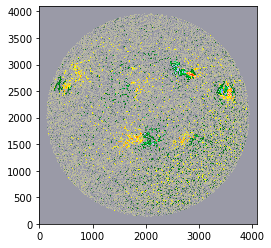

In [10]:
 in_batch, in_channels, in_width, in_height = patchesMDI.shape
patchesMDI_upsampled = F.upsample(torch.tensor(patchesMDI).reshape(in_batch,in_channels,in_width, in_height), size=patchesHMI.shape[-2:],
                                     mode='bicubic', align_corners=False)
bicubic = get_img_from_patch(patchesMDI_upsampled)
plt.imshow(bicubic,vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')

875
-672.9068 301.16858


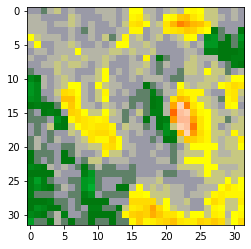

In [15]:
#Select random patch
inx = int(np.floor(np.random.rand()*patchesMDI.shape[0]))
print(inx)
# inx = 712
inx = 611
# inx = 340
# inx = 652
# inx = 646
# inx = 407
# inx = 410
# inx = 786

# Turn it into torch
tmp_patch = torch.tensor(patchesMDI[inx:inx+1,:,:,:]).to(device).float()
# tmp_patch[0,1,:,:] = tmp_patch[0,1,:,:]*3500

# Do inference?
# tmp_inf = model.forward(tmp_patch/3500)*3500
tmp_inf = model.net.forward(tmp_patch.float()/3500).detach().cpu().numpy()*3500
plt.imshow(patchesMDI[inx,0,:,:], vmin=vmin, vmax=vmax, cmap=current_cmap)
print(np.min(tmp_inf), np.max(tmp_inf))

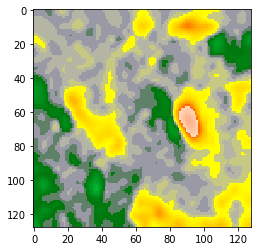

In [16]:
plt.imshow(patchesMDI_upsampled[inx,0,:,:], vmin=vmin, vmax=vmax, cmap=current_cmap) 

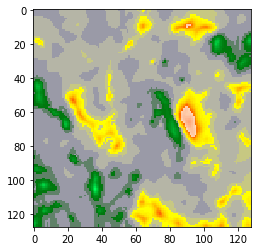

In [17]:
 plt.imshow(tmp_inf[0,:,:], vmin=vmin, vmax=vmax,cmap=current_cmap)

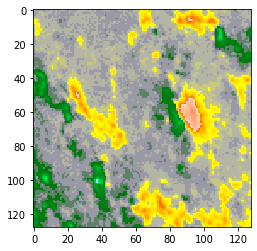

In [18]:
 plt.imshow(patchesHMI[inx,0,:,:], vmin=vmin, vmax=vmax, cmap=current_cmap)